In [1]:
import numpy as np
import odl
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
from odl.phantom import shepp_logan
from scipy import io
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import cv2
import os
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
# ========== 可调参数 ==========
image_size = 128          # 图像大小
scale = 0.01             # 缩放因子
n_theta = 180           # 射线方向数量
n_s = 100                  # 每条射线的积分点数
n_iter = 5                # 迭代次数
lambda_reg = 0.1           # 正则化系数
# ============================

In [3]:
# ========== 1. 创建空间与 Phantom ==========
space = odl.uniform_discr(min_pt=[-20, -20], max_pt=[20, 20], shape=[image_size, image_size], dtype='float64')

# 生成 Shepp-Logan phantom
f_orig = shepp_logan(space,modified=True)
f = scale * f_orig


# ========== 2. 创建插值器 ==========
def make_interp(f):
    """ 创建插值器 """
    if isinstance(f, np.ndarray):  # 判断f是否是numpy.ndarray类型
        f = space.element(f)  # 将f转换为odl元素
    
    grid_x, grid_y = space.grid.coord_vectors
    return RegularGridInterpolator((grid_x, grid_y), f.asarray(), bounds_error=False, fill_value=0.0)


In [4]:
print(f_orig.data.min())

0.0


In [5]:
from joblib import Parallel, delayed

def compute_Kf(f, n_theta=90, n_s=100):
    """ 计算 Kf(x, θ)，即沿射线方向的积分（并行化版本） """
    f_interp = make_interp(f)
    thetas = np.linspace(0, np.pi, n_theta, endpoint=False)  # 射线方向
    directions = np.stack([np.cos(thetas), np.sin(thetas)], axis=1)  # 射线方向向量
    s_vals = np.linspace(-30, 30, n_s)  # 每条射线上的采样点
    s_grid = s_vals[:, None]  # 转换为列向量，方便后续计算

    coords = space.points()
    X = coords[:, 0].reshape(space.shape)
    Y = coords[:, 1].reshape(space.shape)

    def compute_single_pixel(i, j):
        x0 = np.array([X[i, j], Y[i, j]])  # 当前坐标
        integral = 0.0
        for theta in directions:  # 遍历所有射线方向
            points = x0[None, :] + s_grid * theta[None, :]  # 沿射线方向积分
            vals = f_interp(points)
            Xf_theta = np.trapz(vals, s_vals)  # 沿射线积分得到 Xf(x, θ)
            integral += np.exp(-Xf_theta)  # 累加每条射线的结果
        return  integral / n_theta  # 平均所有射线方向的结果

    # 使用并行计算每个像素点的射线变换
    Kf = np.array(Parallel(n_jobs=-1)(delayed(compute_single_pixel)(i, j) for i in range(space.shape[0]) for j in range(space.shape[1])))
    return Kf.reshape(space.shape)

In [7]:
Kf_measured = compute_Kf(f, n_theta=n_theta, n_s=n_s)

In [8]:
print(Kf_measured.max())

0.987273674832


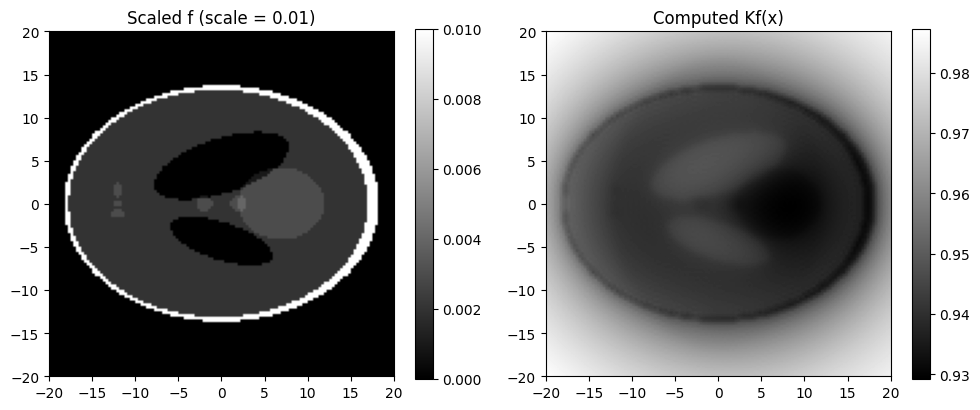

In [10]:
# 可视化
extent = [
    space.domain.min_pt[0], space.domain.max_pt[0],
    space.domain.min_pt[1], space.domain.max_pt[1],
]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title(f"Scaled f (scale = {scale})")
plt.imshow(f.asarray(), cmap='gray', extent=extent)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Computed Kf(x)")
plt.imshow(Kf_measured, cmap='gray', extent=extent)
plt.colorbar()

plt.tight_layout()
plt.show()

In [11]:
def generate_ellipse_phantom():
    img = np.zeros((image_size, image_size), dtype=np.float32)
    for _ in range(np.random.randint(6, 12)):
        a, b = np.random.uniform(0.1, 0.4, 2)
        angle = np.random.uniform(0, np.pi)
        x0, y0 = np.random.uniform(-0.5, 0.5, 2)

        rr, cc = np.ogrid[:image_size, :image_size]
        x = (cc - image_size / 2) / (image_size / 2)
        y = (rr - image_size / 2) / (image_size / 2)
        ellipse = (((x - x0) * np.cos(angle) + (y - y0) * np.sin(angle))**2 / a**2 +
                   ((x - x0) * np.sin(angle) - (y - y0) * np.cos(angle))**2 / b**2) <= 1

        intensity = np.random.uniform(0.3, 1.0)
        alpha = np.random.uniform(0.2, 0.7)
        img[ellipse] = alpha * intensity + (1 - alpha) * img[ellipse]

    return np.clip(img, 0, 1)

In [12]:
# ====== 生成数据集并保存 ======
def generate_and_save_dataset(image_size=128, num_images=100):
    dataset_f = []
    dataset_Kf = []
    
    # 生成多个图像及其投影数据
    for i in tqdm(range(num_images), desc="Generating dataset", unit="image"):
        f = generate_ellipse_phantom()
        f = scale * f
        Kf = compute_Kf(f)
        noise_std = 1e-6
        Kf += np.random.normal(loc=0.0, scale=noise_std, size=Kf.shape)
        dataset_f.append(f)
        dataset_Kf.append(Kf)
    
    # 随机选择1张进行可视化
    indices = np.random.choice(num_images, 1, replace=False)
    for idx in indices:
        f = dataset_f[idx]
        Kf = dataset_Kf[idx]
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(f, cmap='gray')
        axes[0].set_title(f"Original Image {idx + 1}")
        axes[0].axis('off')
        
        axes[1].imshow(Kf, cmap='gray')
        axes[1].set_title(f"Projection Kf {idx + 1}")
        axes[1].axis('off')
        
        plt.show()
    
    # 保存数据集
    np.save('dataset_f.npy', np.array(dataset_f))
    np.save('dataset_Kf.npy', np.array(dataset_Kf))
    print("Dataset saved to 'dataset_f.npy' and 'dataset_Kf.npy'")




Generating dataset: 100%|██████████| 150/150 [22:46<00:00,  9.11s/image]


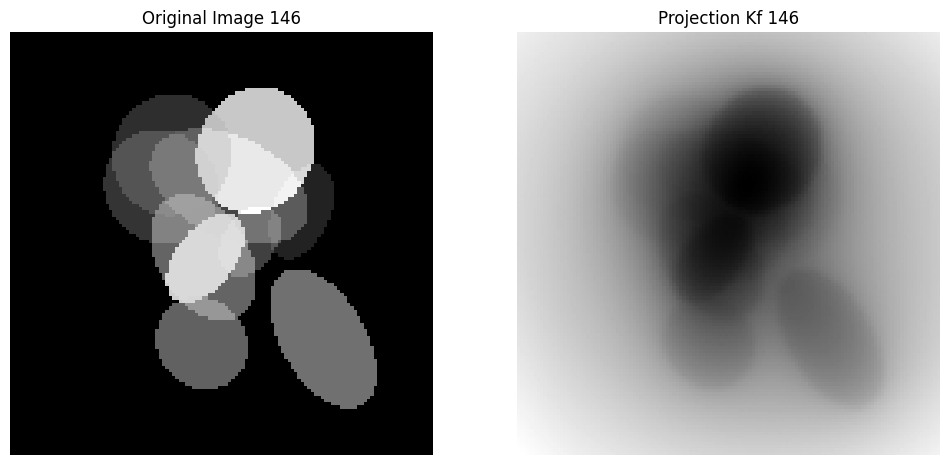

Dataset saved to 'dataset_f.npy' and 'dataset_Kf.npy'


In [325]:
# 生成数据集并可视化
#generate_and_save_dataset(image_size=128, num_images=150)

In [15]:
folder_path = r'F:\dlinverse\datasetCTBrain\no'
f_list = []

for file in os.listdir(folder_path):
    if file.lower().endswith(('.jpg', '.jpeg')):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path).convert('L')  # 转为灰度
        img = img.resize((image_size, image_size), resample=Image.BICUBIC)
        f = np.array(img).astype(np.float32)

        # Min-Max 归一化
        f_norm = (f - f.min()) / (f.max() - f.min() + 1e-8)
        f_list.append(f_norm)


In [16]:
# 转为 NumPy 数组
dataset_f_ct = np.array(f_list)

In [17]:
dataset_f_ct.shape

(97, 128, 128)

In [ ]:
# dataset_Kf_ct = []
# for f in dataset_f_ct:
#     f = scale * f
#     Kf = compute_Kf(f) 
#     dataset_Kf_ct.append(Kf)

# dataset_Kf_ct = np.array(dataset_Kf_ct)


In [ ]:
# np.save('dataset_f_ct.npy', dataset_f_ct)      # 灰度图像，归一化后的 CT 图
# np.save('dataset_Kf_ct.npy', dataset_Kf_ct)    # 对应的投影图像

In [13]:
f_ct = np.load('dataset_f_ct.npy')
Kf_ct = np.load('dataset_Kf_ct.npy')

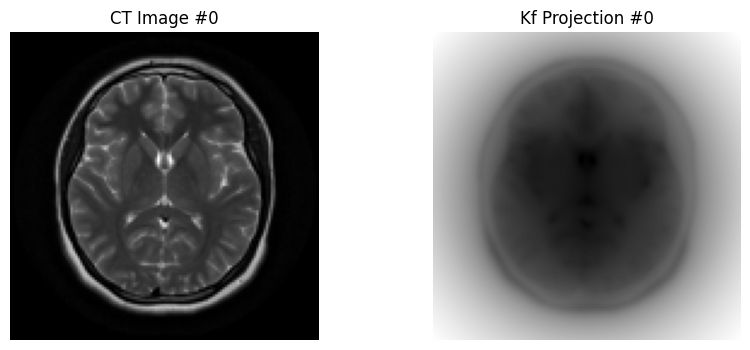

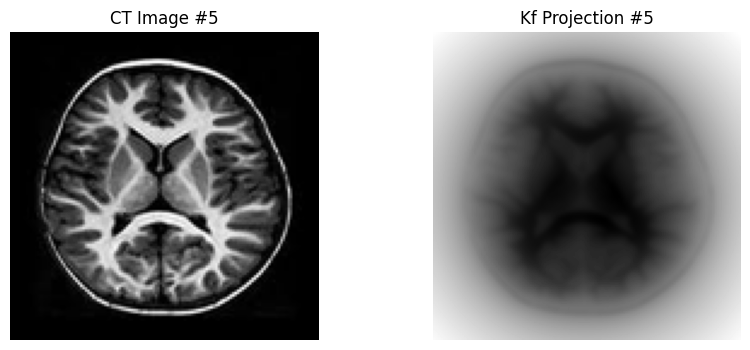

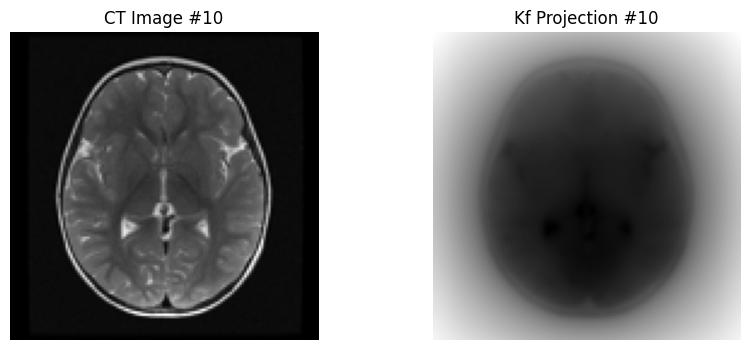

In [14]:
indices = [0, 5, 10]
for idx in indices:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(f_ct[idx], cmap='gray')
    plt.title(f"CT Image #{idx}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Kf_ct[idx], cmap='gray')
    plt.title(f"Kf Projection #{idx}")
    plt.axis('off')
    plt.show()


In [15]:
def preprocess_image(f_img, Kf_img, augment=True):
    f_img = tf.cast(f_img, tf.float32)
    Kf_img = tf.cast(Kf_img, tf.float32)

    if augment:
        seed = tf.random.uniform(shape=[], maxval=1000, dtype=tf.int32)
        f_img = tf.image.stateless_random_flip_left_right(f_img, seed=[seed, 0])
        Kf_img = tf.image.stateless_random_flip_left_right(Kf_img, seed=[seed, 0])
        f_img = tf.image.stateless_random_brightness(f_img, max_delta=0.05, seed=[seed, 1])
        Kf_img = tf.image.stateless_random_brightness(Kf_img, max_delta=0.05, seed=[seed, 1])

    # 对每张图像再归一化一次（以确保增强后仍在 0~1）
    def normalize_single(img):
        min_val = tf.reduce_min(img)
        max_val = tf.reduce_max(img)
        return (img - min_val) / (max_val - min_val + 1e-8)

    return normalize_single(Kf_img), normalize_single(f_img)


In [16]:
# ====== 加载数据集 ======
def load_dataset(augment=True, batch_size=4, val_split=0.2, shuffle=True):
    dataset_f0 = np.load('dataset_f.npy')
    dataset_Kf0 = np.load('dataset_Kf.npy')
    dataset_f = np.concatenate([dataset_f0, f_ct], axis=0)
    dataset_Kf = np.concatenate([dataset_Kf0, Kf_ct], axis=0)

    # 增加通道维度：-> (50, 128, 128, 1)
    dataset_f = dataset_f[..., np.newaxis].astype(np.float32)
    dataset_Kf = dataset_Kf[..., np.newaxis].astype(np.float32)

    # 打乱顺序并切分
    N = dataset_f.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)

    split_index = int(N * (1 - val_split))
    train_idx, val_idx = indices[:split_index], indices[split_index:]

    # 拆分数据
    train_f, train_Kf = dataset_f[train_idx], dataset_Kf[train_idx]
    val_f, val_Kf = dataset_f[val_idx], dataset_Kf[val_idx]

    # 构建 Dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_Kf, train_f))
    train_ds = train_ds.map(lambda Kf, f: preprocess_image(f, Kf, augment=augment),
                            num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((val_Kf, val_f))
    val_ds = val_ds.map(lambda Kf, f: preprocess_image(f, Kf, augment=False),
                        num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

(4, 128, 128, 1) (4, 128, 128, 1)


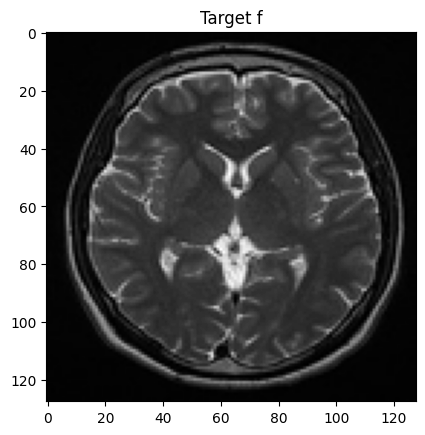

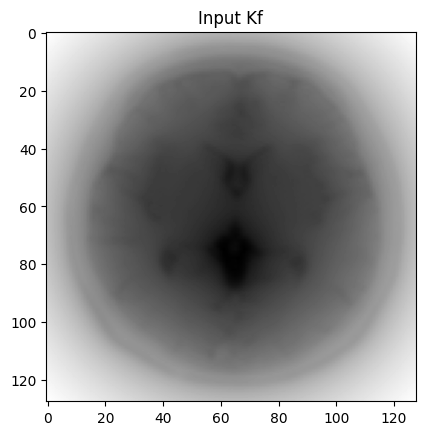

In [20]:
# 加载数据集
train_dataset, validation_dataset = load_dataset()

for x in train_dataset.take(1):
    print(x[0].shape, x[1].shape)

for x in train_dataset.take(1):
    plt.imshow(tf.squeeze(x[1][0]), cmap='gray')  # 第一个样本的目标图
    plt.title("Target f")
    plt.show()
    
    plt.imshow(tf.squeeze(x[0][0]), cmap='gray')  # 对应的输入图 Kf
    plt.title("Input Kf")
    plt.show()

In [21]:
print("训练集：")
print("Kf shape:", train_dataset.element_spec[0].shape)
print("f shape:", train_dataset.element_spec[1].shape)
print("dtype:", train_dataset.element_spec[0].dtype)

print("\n验证集：")
print("Kf shape:", validation_dataset.element_spec[0].shape)
print("f shape:", validation_dataset.element_spec[1].shape)


训练集：
Kf shape: (None, 128, 128, 1)
f shape: (None, 128, 128, 1)
dtype: <dtype: 'float32'>

验证集：
Kf shape: (None, 128, 128, 1)
f shape: (None, 128, 128, 1)


In [22]:
for x in train_dataset.take(1):
    Kf_batch, f_batch = x

    print("Kf - min:", tf.reduce_min(Kf_batch).numpy(), "max:", tf.reduce_max(Kf_batch).numpy())
    print("f  - min:", tf.reduce_min(f_batch).numpy(), "max:", tf.reduce_max(f_batch).numpy())


Kf - min: 0.0 max: 1.0
f  - min: 0.0 max: 1.0


In [23]:
# Step 1: 检查标签范围
for x in train_dataset.take(1):
    print("f range:", tf.reduce_min(x[1]).numpy(), tf.reduce_max(x[1]).numpy())

# # Step 2: 先换成纯 MSE loss
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# # Step 3: 验证训练是否有效
# history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3)
# print(history.history['loss'])


f range: 0.0 1.0


In [25]:
from tensorflow.keras import layers

class AttentionGate(layers.Layer):
    def __init__(self, inter_channels, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.inter_channels = inter_channels

    def build(self, input_shape):
        # x: encoder 特征图，g: decoder 特征图
        self.theta_x = layers.Conv2D(self.inter_channels, 1, padding='same')
        self.phi_g = layers.Conv2D(self.inter_channels, 1, padding='same')
        self.psi = layers.Conv2D(1, 1, padding='same')

    def call(self, inputs):
        x, g = inputs  # 解构输入
        theta_x = self.theta_x(x)
        phi_g = self.phi_g(g)
        add = tf.keras.layers.Add()([theta_x, phi_g])
        act = tf.keras.activations.relu(add)
        psi = tf.keras.activations.sigmoid(self.psi(act))
        return tf.keras.layers.Multiply()([x, psi])

    def get_config(self):
        config = super().get_config()
        config.update({'inter_channels': self.inter_channels})
        return config


In [26]:
from tensorflow.keras import models

# Attention Gate 模块
def attention_gate(x, g, inter_channels):
    theta_x = layers.Conv2D(inter_channels, 1, padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, 1, padding='same')(g)
    add = layers.Add()([theta_x, phi_g])
    act = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, 1, padding='same')(act)
    psi = layers.Activation('sigmoid')(psi)
    att = layers.Multiply()([x, psi])
    return att

# 主模型
def build_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)

    # --- Encoder ---
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # --- Bottleneck ---
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    b = layers.Dropout(0.3)(b)
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(b)

    # --- Decoder with Attention ---
    u3 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(b)
    #att3 = attention_gate(c3, u3, inter_channels=128)
    att3 = AttentionGate(inter_channels=128)([c3, u3])
    u3 = layers.concatenate([u3, att3])
    d3 = layers.Conv2D(256, 3, activation='relu', padding='same')(u3)
    d3 = layers.Conv2D(256, 3, activation='relu', padding='same')(d3)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(d3)
    #att2 = attention_gate(c2, u2, inter_channels=64)
    att2 = AttentionGate(inter_channels=64)([c2, u2])
    u2 = layers.concatenate([u2, att2])
    d2 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    d2 = layers.Conv2D(128, 3, activation='relu', padding='same')(d2)

    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(d2)
    #att1 = attention_gate(c1, u1, inter_channels=32)
    att1 = AttentionGate(inter_channels=32)([c1, u1])
    u1 = layers.concatenate([u1, att1])
    d1 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    d1 = layers.Conv2D(64, 3, activation='relu', padding='same')(d1)

    # --- Output ---
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d1)

    model = models.Model(inputs, outputs)
    return model


In [27]:
def mixed_loss(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.5 * mse + 0.5 * (1 - ssim)

In [64]:
model = build_unet(input_shape=(128, 128, 1))
model.compile(optimizer=Adam(learning_rate=2e-4), loss=mixed_loss, metrics=['mae'])
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 128, 128, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 128, 64  256        ['conv2d_45[0][0]']              
 rmalization)                   )                                                           

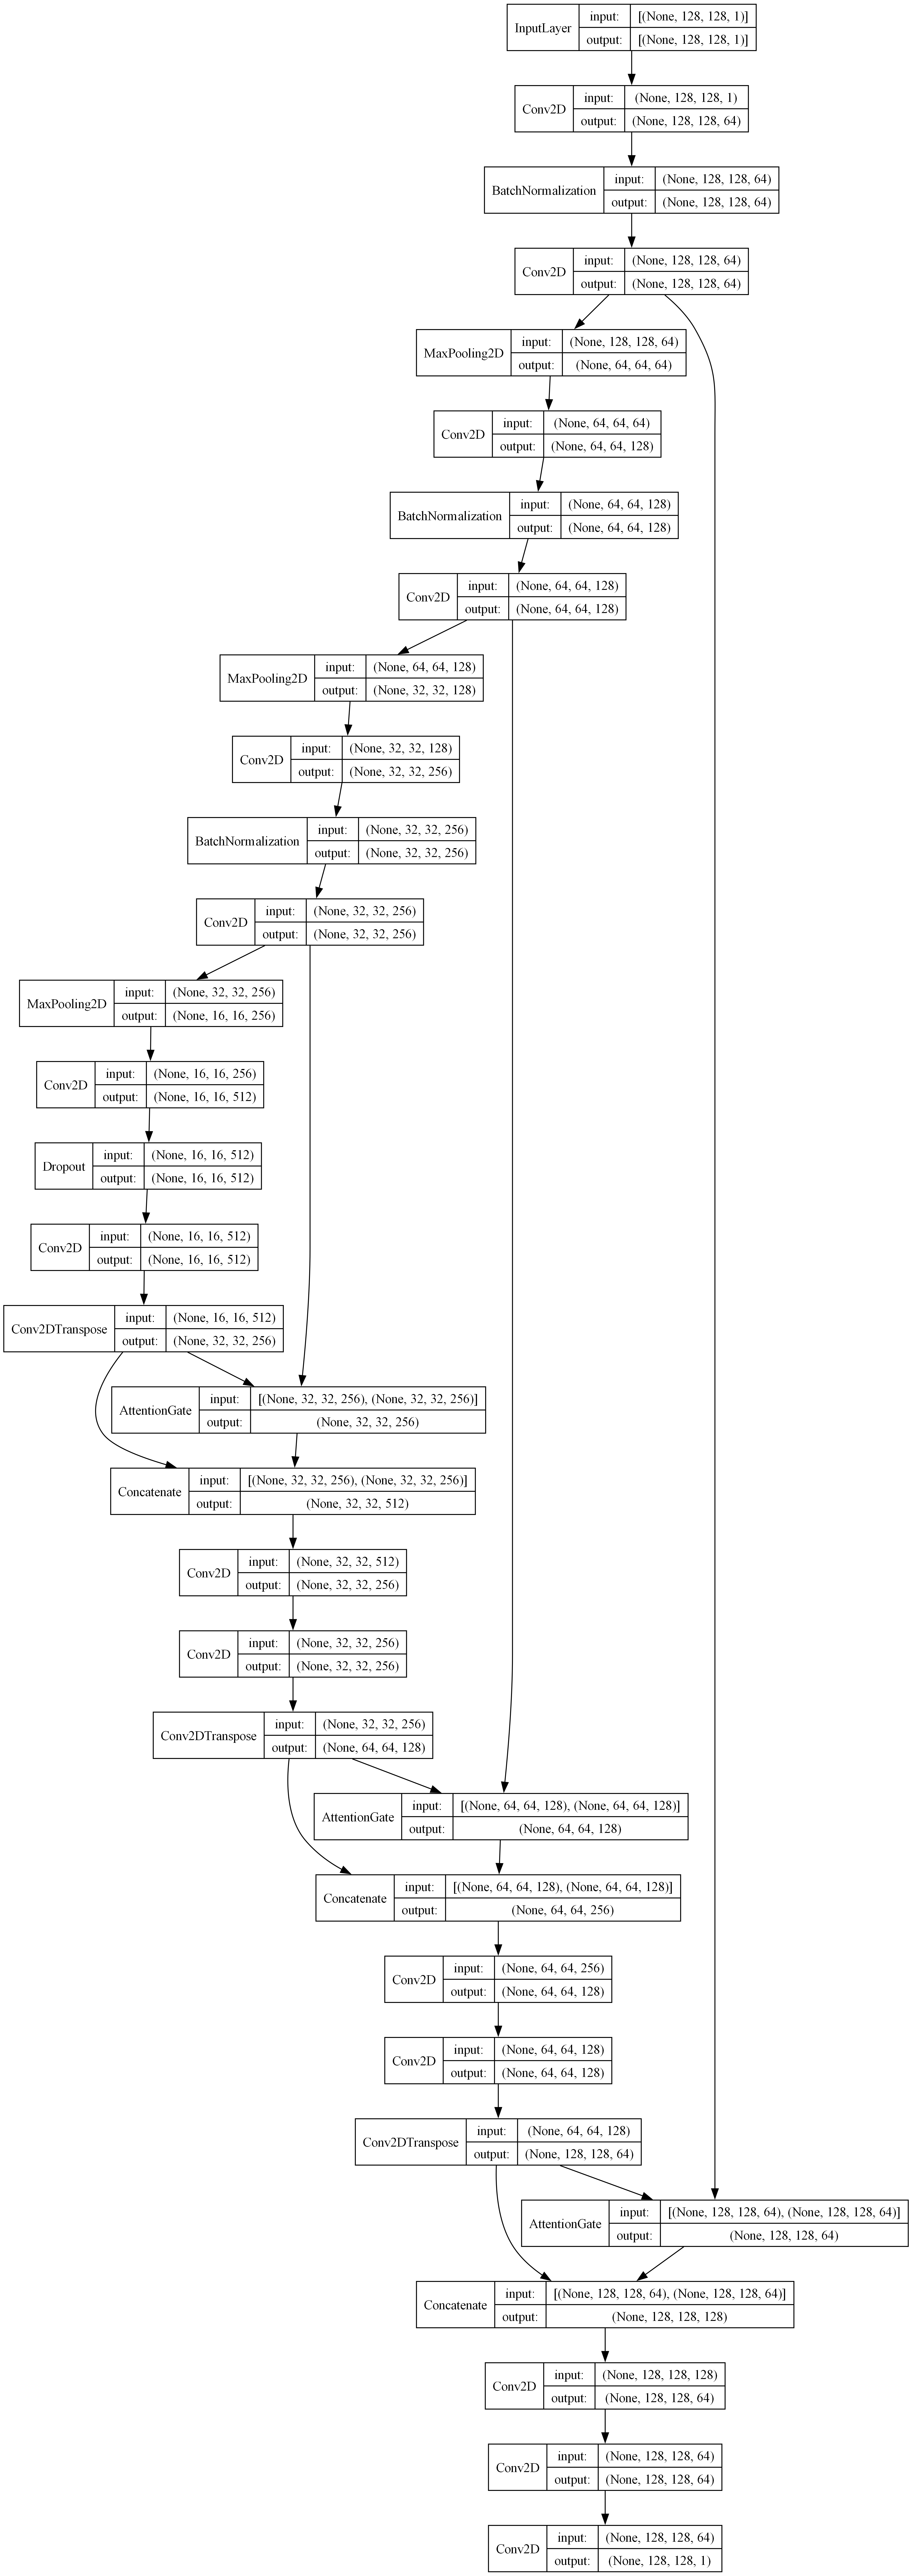

In [22]:
# 生成结构图并保存为PDF/PNG
plot_model(
    model,
    to_file="unet_attention_architecture.png",
    show_shapes=True,
    show_layer_names=False,
    dpi=300,
    expand_nested=True
)


In [65]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=150)

Epoch 1/150
50/50 [==============================] - 5s 55ms/step - loss: 0.2794 - mae: 0.1255 - val_loss: 0.4106 - val_mae: 0.1415
Epoch 2/150
50/50 [==============================] - 2s 46ms/step - loss: 0.1651 - mae: 0.0636 - val_loss: 0.3825 - val_mae: 0.1516
Epoch 3/150
50/50 [==============================] - 2s 47ms/step - loss: 0.1266 - mae: 0.0561 - val_loss: 0.3341 - val_mae: 0.1641
Epoch 4/150
50/50 [==============================] - 2s 47ms/step - loss: 0.1103 - mae: 0.0529 - val_loss: 0.3318 - val_mae: 0.1637
Epoch 5/150
50/50 [==============================] - 2s 46ms/step - loss: 0.0977 - mae: 0.0476 - val_loss: 0.2905 - val_mae: 0.1368
Epoch 6/150
50/50 [==============================] - 2s 47ms/step - loss: 0.0832 - mae: 0.0453 - val_loss: 0.2476 - val_mae: 0.0965
Epoch 7/150
50/50 [==============================] - 2s 47ms/step - loss: 0.0784 - mae: 0.0410 - val_loss: 0.2039 - val_mae: 0.0844
Epoch 8/150
50/50 [==============================] - 2s 48ms/step - loss: 0.

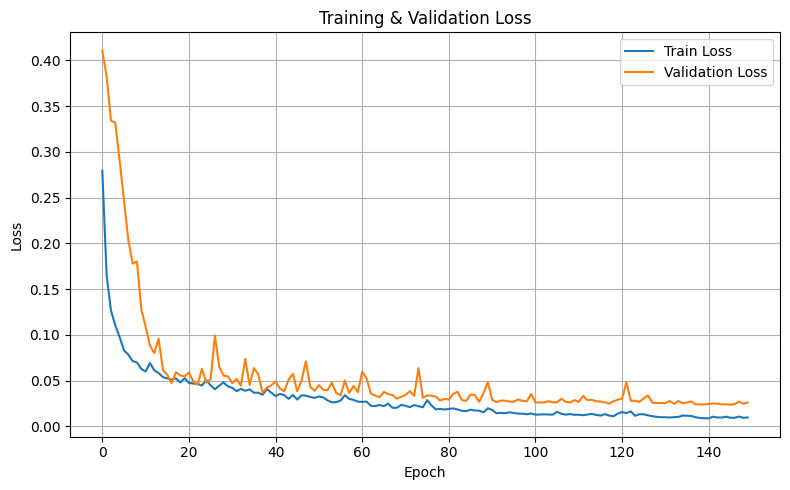

In [66]:
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss(history)


In [31]:
# 保存模型
model.save('cnn_reconstruction_model.h5')

In [71]:
for x in validation_dataset.take(1):
    val_inputs, val_targets = x  # Kf, f
    break  # 只取一个 batch

val_preds = model.predict(val_inputs)  # 输出 shape: (batch, 128, 128, 1)


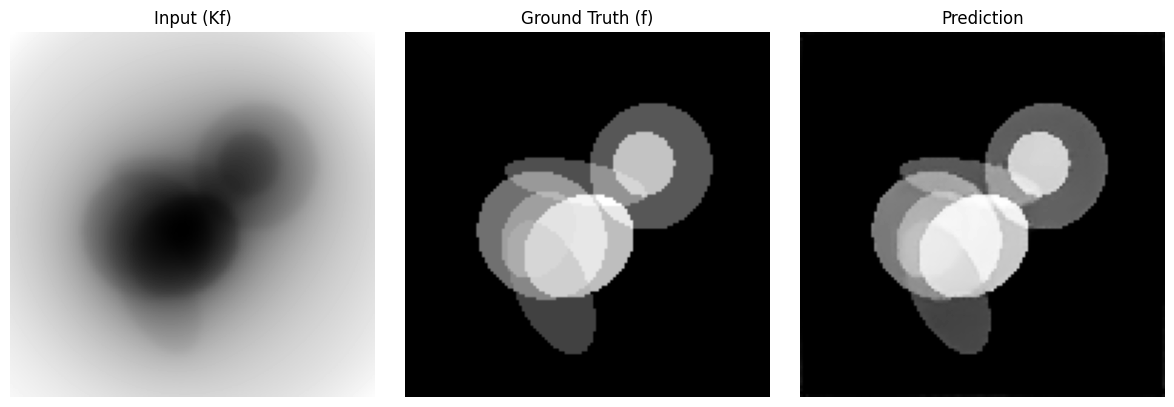

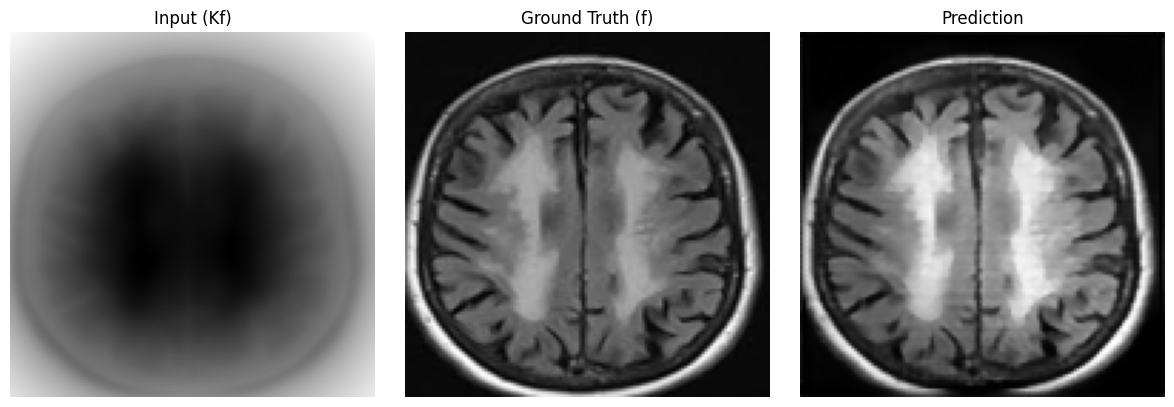

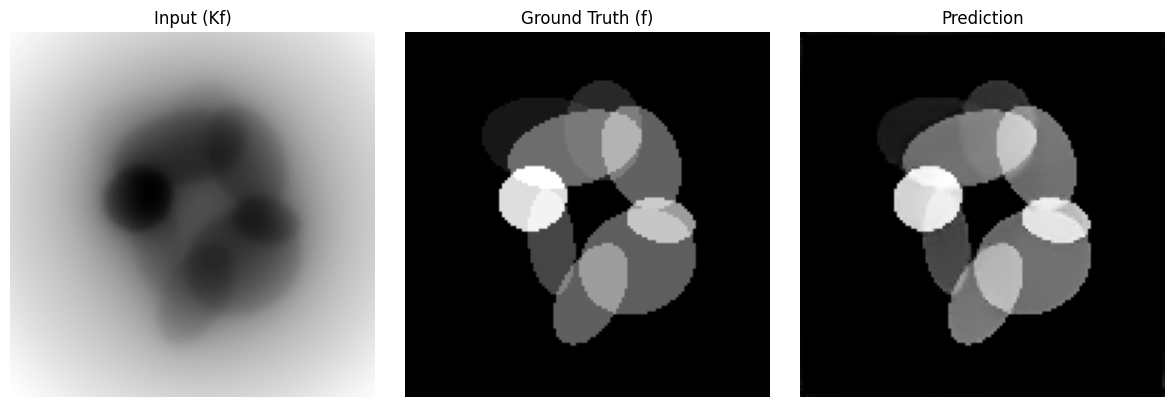

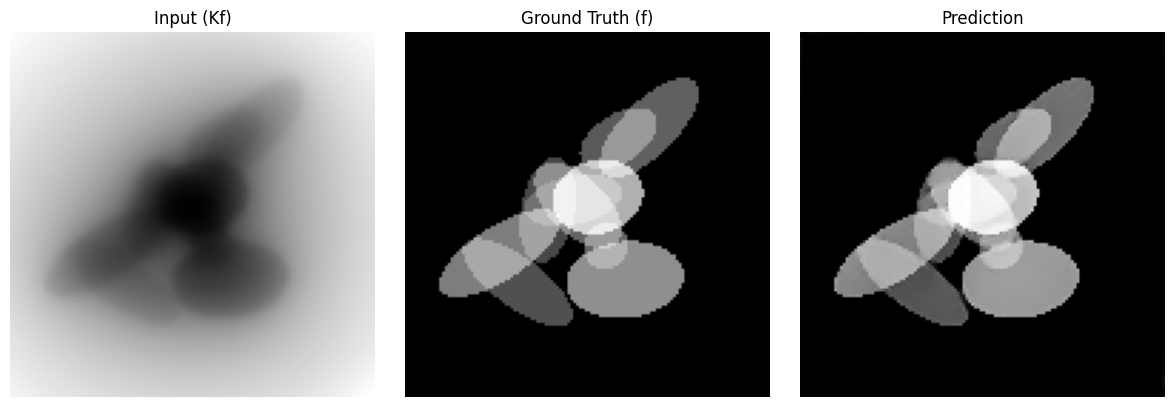

In [72]:
def show_comparison(pred, target, input_img, idx=0):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(tf.squeeze(input_img[idx]), cmap='gray')
    axes[0].set_title("Input (Kf)")

    axes[1].imshow(tf.squeeze(target[idx]), cmap='gray')
    axes[1].set_title("Ground Truth (f)")

    axes[2].imshow(tf.squeeze(pred[idx]), cmap='gray')
    axes[2].set_title("Prediction")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 展示前4个样本
for i in range(4):
    show_comparison(val_preds, val_targets, val_inputs, idx=i)


In [73]:
def evaluate_psnr_ssim(preds, targets):
    psnr_list = []
    ssim_list = []
    
    for i in range(preds.shape[0]):
        pred = preds[i]     # shape: (128, 128, 1)
        target = targets[i] # shape: (128, 128, 1)

        
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)
        target = tf.convert_to_tensor(target, dtype=tf.float32)
        
        psnr = tf.image.psnr(pred, target, max_val=1.0).numpy()
        ssim = tf.image.ssim(pred, target, max_val=1.0).numpy()
        
        psnr_list.append(psnr)
        ssim_list.append(ssim)

    return np.mean(psnr_list), np.mean(ssim_list), psnr_list, ssim_list



In [74]:
mean_psnr, mean_ssim, psnr_list, ssim_list = evaluate_psnr_ssim(val_preds, val_targets)

print(f"平均 PSNR: {mean_psnr:.2f} dB")
print(f"平均 SSIM: {mean_ssim:.4f}")
print(ssim_list)


平均 PSNR: 29.65 dB
平均 SSIM: 0.9639
[0.99323195, 0.88361675, 0.98760653, 0.9910723]


In [54]:
test_dataset_f = []
test_dataset_Kf = []

num_images = 10
# # 生成多个图像及其投影数据
for i in tqdm(range(num_images), desc="Generating dataset", unit="image"):
    f_test = generate_ellipse_phantom()
    f_test = scale * f_test
    Kf_test = compute_Kf(f_test)
    noise_std = 1e-6
    Kf_test += np.random.normal(loc=0.0, scale=noise_std, size=Kf_test.shape)
    test_dataset_f.append(f_test)
    test_dataset_Kf.append(Kf_test)

Generating dataset: 100%|██████████| 10/10 [02:24<00:00, 14.43s/image]


In [55]:
# Min-Max 归一化每张图
def normalize_batch(data):
    min_val = np.min(data, axis=(1, 2, 3), keepdims=True)
    max_val = np.max(data, axis=(1, 2, 3), keepdims=True)
    return (data - min_val) / (max_val - min_val + 1e-8)

In [56]:
# 转为 NumPy 数组并归一化
test_dataset_f = np.array(test_dataset_f)[..., np.newaxis]  # (N, 128, 128, 1)
test_dataset_Kf = np.array(test_dataset_Kf)[..., np.newaxis]

test_dataset_f = normalize_batch(test_dataset_f)
test_dataset_Kf = normalize_batch(test_dataset_Kf)

test_dataset_f = np.reshape(test_dataset_f, (-1, 128, 128, 1))
test_dataset_Kf = np.reshape(test_dataset_Kf, (-1, 128, 128, 1))


# 转为 TensorFlow Dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_dataset_Kf, test_dataset_f))
test_ds = test_ds.batch(4)  

In [57]:
print("Input shape before predict:", test_dataset_Kf.shape)


Input shape before predict: (10, 128, 128, 1)


In [75]:
# 模型预测
preds = model.predict(test_dataset_Kf, batch_size=4)  # shape: (N, 128, 128, 1)


In [76]:
def show_test_results(inputs, targets, predictions, idx=0, title_prefix=""):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(tf.squeeze(inputs[idx]), cmap='gray')
    axes[0].set_title(f"{title_prefix}Input (Kf)")

    axes[1].imshow(tf.squeeze(targets[idx]), cmap='gray')
    axes[1].set_title(f"{title_prefix}Ground Truth (f)")

    axes[2].imshow(tf.squeeze(predictions[idx]), cmap='gray')
    axes[2].set_title(f"{title_prefix}Prediction")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


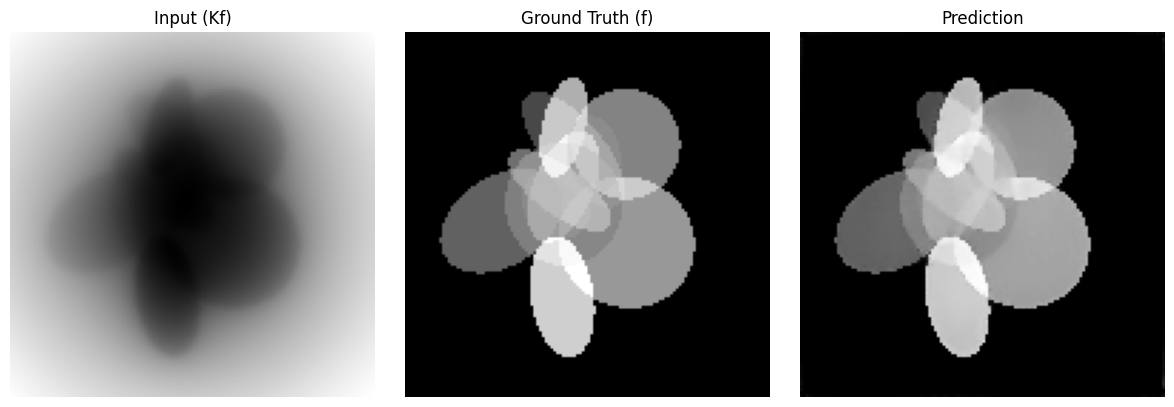

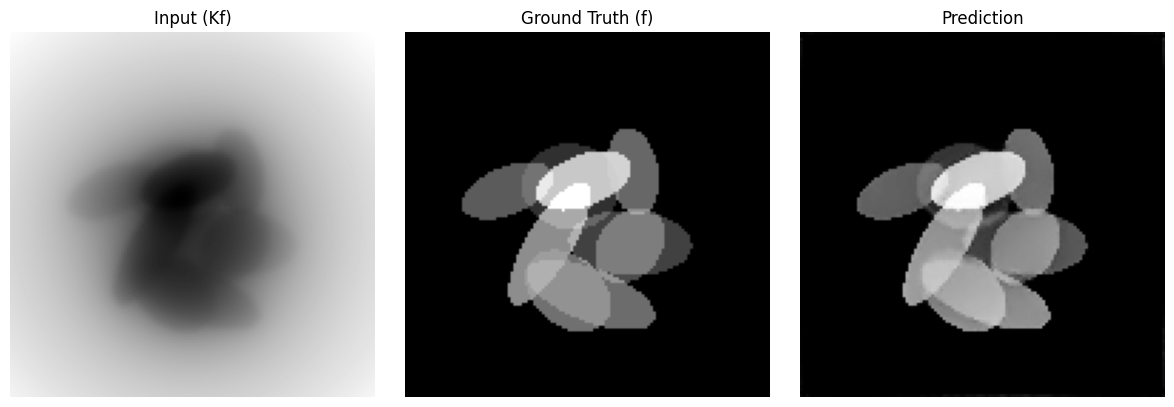

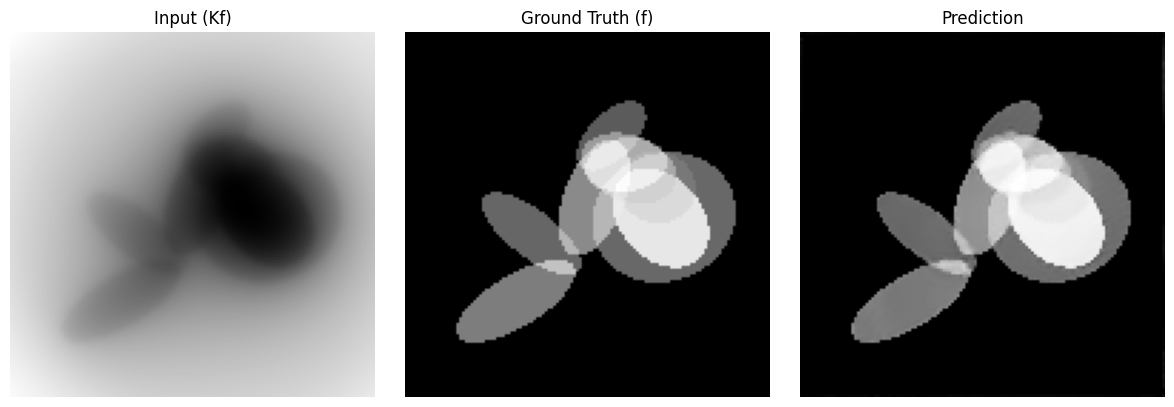

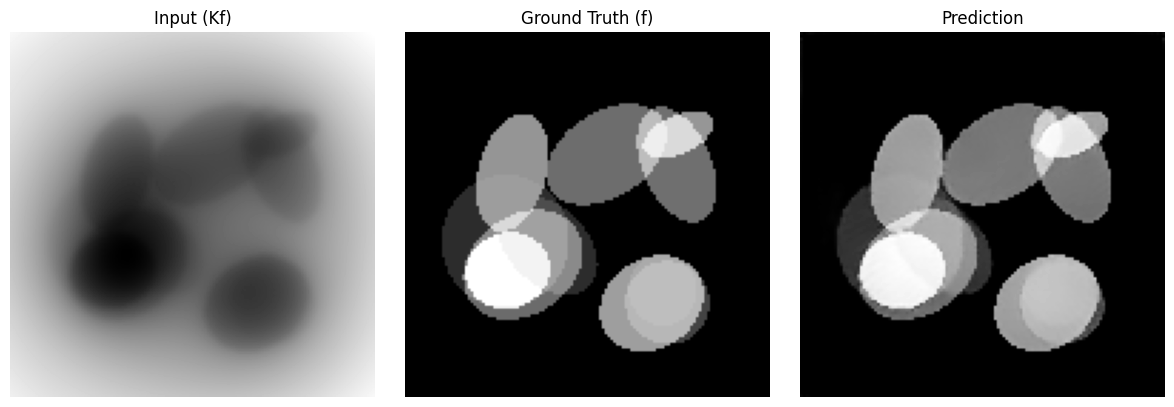

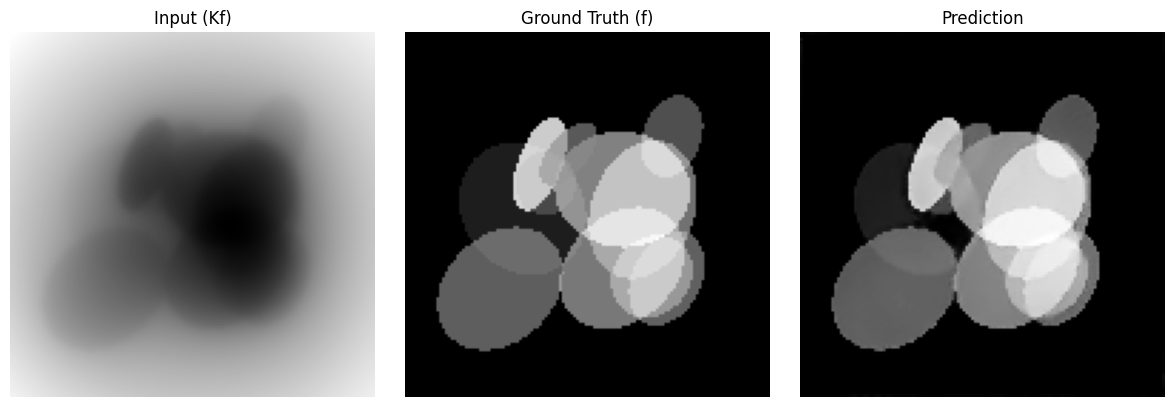

In [77]:
for i in range(5):
    show_test_results(test_dataset_Kf, test_dataset_f, preds, idx=i)


In [40]:
# ========== Shepp-Logan Phantom ==========
f_orig = shepp_logan(space, modified=True)
f = scale * f_orig
Kf_measured = compute_Kf(f, n_theta=n_theta, n_s=n_s)

In [41]:
#给投影添加噪声
noise_std = 1e-6
Kf_measured += np.random.normal(loc=0.0, scale=noise_std, size=Kf_measured.shape)

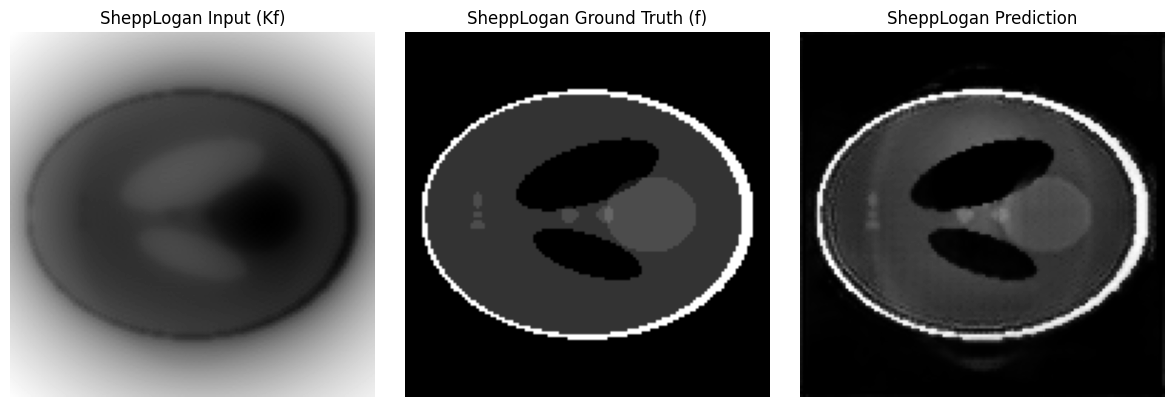

In [78]:
# 转为张量 + 归一化 + reshape
f_gt = f.asarray()[np.newaxis, ..., np.newaxis]  # shape: (1, 128, 128, 1)
Kf_input = Kf_measured[np.newaxis, ..., np.newaxis]

# 同样归一化
f_gt = normalize_batch(f_gt)
Kf_input = normalize_batch(Kf_input)

# 预测
f_pred = model.predict(Kf_input)

# 可视化
show_test_results(Kf_input, f_gt, f_pred, idx=0, title_prefix="SheppLogan ")

In [79]:
for i in range(3):
    gt = tf.squeeze(test_dataset_f[i]).numpy()
    pred = tf.squeeze(preds[i]).numpy()
    ssim_score = ssim(gt, pred, data_range=1.0)
    psnr_score = psnr(gt, pred, data_range=1.0)
    print(f"SSIM: {ssim_score:.4f}")
    print(f"PSNR: {psnr_score:.2f} dB")
mean_ssim = 0
mean_psnr = 0
for i in range(10):
    gt = tf.squeeze(test_dataset_f[i]).numpy()
    pred = tf.squeeze(preds[i]).numpy()
    ssim_score = ssim(gt, pred, data_range=1.0)
    psnr_score = psnr(gt, pred, data_range=1.0)
    mean_ssim += ssim_score / 10
    mean_psnr += psnr_score / 10

print(f"mean_SSIM: {ssim_score:.4f}")
print(f"mean_PSNR: {psnr_score:.2f} dB")

SSIM: 0.9879
PSNR: 34.07 dB
SSIM: 0.9830
PSNR: 31.21 dB
SSIM: 0.9884
PSNR: 34.66 dB
mean_SSIM: 0.9870
mean_PSNR: 34.27 dB


In [80]:
f_gt = tf.squeeze(f_gt).numpy()
f_pred = tf.squeeze(f_pred).numpy()
ssim_score = ssim(f_gt, f_pred, data_range=1.0)
psnr_score = psnr(f_gt, f_pred, data_range=1.0)

print(f"Shepp-Logan SSIM: {ssim_score:.4f}")
print(f"Shepp-Logan PSNR: {psnr_score:.2f} dB")


Shepp-Logan SSIM: 0.8271
Shepp-Logan PSNR: 26.27 dB
